<a href="https://www.kaggle.com/code/mukaffimoin/imdb-tv-series-reviews-classification-bert?scriptVersionId=158624469" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
Berlin = pd.read_csv("/kaggle/input/top-10-imdb-tv-series/Berlin.csv")
Berlin.head()

,title,review,rating,date
0,disappointing,"The title of this should have been ""the love l...",6.0,30 December 2023
1,Same crap why are they so obsessed with love a...,The Casa de Papel was an excellent idea; the p...,4.0,30 December 2023
2,Another mediocre product of Netflix which is s...,It seems like the budget for promotion is bigg...,1.0,29 December 2023
3,Undisciplined people conducting a heist?,Money Heist was a favourite of mine with all t...,1.0,31 December 2023
4,Don't waste UR time...it is NOT money Heist,Total let down! There is not even a remote re...,3.0,29 December 2023


In [3]:
Doctor_Who = pd.read_csv("/kaggle/input/top-10-imdb-tv-series/Doctor Who.csv")
Doctor_Who.head()

,title,review,rating,date
0,"The 9 is for Season 1 till 10, season 11 is a ...","I'm a 46 year old man, but I'm not ashamed to ...",9.0,2 January 2019
1,Seasons 1-7,Doctor Who was at it's absolute peak with Chri...,8.0,14 March 2021
2,Time passes by so quickly.,I cannot believe it's been back on our screens...,10.0,27 October 2015
3,I thought nothing could kill Dr. Who...,"I thought nothing could kill Dr. Who, but appa...",NaN,25 March 2019
4,The show ended in 2017,Seasons 1 through 10 are brilliant overall. Se...,9.0,23 August 2021


In [4]:
got = pd.read_csv("/kaggle/input/top-10-imdb-tv-series/Game Of Thrones.csv")
got.head()

,title,review,rating,date
0,Amazing,What can be said about Game of Thrones that ha...,10.0,11 November 2023
1,One of the best shows ever,You know a lot people say this about a ton of ...,10.0,10 December 2023
2,Seasons 1-6: outstanding. 7: daft but good. 8:...,Let's say you're reading these reviews and hav...,8.0,21 May 2019
3,Can you just make the remake the season finale?,I'm feeling so heartbroken to see everyone cri...,10.0,9 April 2020
4,This is a television show?,Was over-time on a gradual binge of watching '...,10.0,9 November 2017


In [5]:
Fargo = pd.read_csv("/kaggle/input/top-10-imdb-tv-series/Fargo.csv")
Fargo.head()

,title,review,rating,date
0,Outstanding!,What can I say about Fargo that hasn't already...,9.0,29 September 2022
1,Mind-blowingly brilliant...for two seasons,(Rating and review updated after Season 4). S...,8.0,27 April 2019
2,Great!,Fargo is one of the top rated series on just a...,9.0,15 November 2020
3,Pitch black comedy with great characters and a...,You don't have to have seen the original Coen ...,9.0,4 May 2014
4,Excellent.,"Well, I'm Brazilian and my English is not the ...",9.0,9 April 2021


In [6]:
Jackson = pd.read_csv("/kaggle/input/top-10-imdb-tv-series/Percy Jackson and the Olympians.csv")
Jackson.head()

,title,review,rating,date
0,This is not the same Percy that is in the books,I couldn't care less about the differences in ...,4.0,22 December 2023
1,Ehhh,The personalities for characters Percy and Ann...,5.0,27 December 2023
2,Pleasantly Surprised,"Initially, I had doubts about the show, especi...",9.0,20 December 2023
3,If I had a Time Machine...,I was 11 when I first read Percy Jackson and t...,8.0,21 December 2023
4,Meh,The movie is way better and so are the books. ...,2.0,26 December 2023


In [7]:
Monarch = pd.read_csv("/kaggle/input/top-10-imdb-tv-series/Monarch Legacy of Monsters.csv")
Monarch.head()

,title,review,rating,date
0,"Not enough monsters, too many annoying dialogu...","Update: episode 8. Where is the thrill, the ac...",5.0,1 December 2023
1,When does something happen?,4 episodes and its a dull slog. Unlikable char...,3.0,9 December 2023
2,It's not good,The characters are just so damn unlikable and ...,3.0,6 December 2023
3,Was hoping for better,Being a huge fan of the movies involves Godzil...,5.0,23 December 2023
4,Hollywood's Failed Formula,Why can't Hollywood leave the old family drama...,2.0,4 December 2023


In [8]:
Slow_Horses = pd.read_csv("/kaggle/input/top-10-imdb-tv-series/Slow Horses.csv")
Slow_Horses.head()

,title,review,rating,date
0,Crusty old curmudgeon,Gary Oldman plays the quintessential crusty ol...,9.0,2 December 2022
1,Solid Spy Series!,Slow Horses is a pretty good spy thriller that...,8.0,24 December 2022
2,"Finally! A good spy series - by the Brits, of ...",I watched this because I'd been watching forei...,9.0,27 June 2022
3,Better Than Expected,I wasn't expecting to enjoy Slow Horses as muc...,8.0,15 April 2023
4,Loving it....,"Gary Oldman is brilliant, just brilliant. I've...",10.0,5 April 2022


In [9]:
Crown = pd.read_csv("/kaggle/input/top-10-imdb-tv-series/The Crown.csv")
Crown.head()

,title,review,rating,date
0,Brilliant,What can I say about The Crown that hasn't alr...,9.0,14 September 2023
1,"Slick and well executed, the Crown is drama at...",The Crown boasts no action sequences or big mo...,7.0,4 November 2016
2,Brilliant!,The Crown is simply a brilliant piece of telev...,9.0,17 May 2020
3,Brilliant,I have to be honest. I had refused to watch th...,9.0,20 September 2022
4,A Visual Stunner,Regardless of what you may think of the Royals...,10.0,11 November 2016


In [10]:
What_If = pd.read_csv("/kaggle/input/top-10-imdb-tv-series/What If.csv")
What_If.head()

,title,review,rating,date
0,"Great scenarios, but varies between episode","Now that the first season is over, I can confi...",8.0,10 October 2021
1,Cool series with interesting twists n tales.,This is fun. I am enjoying every story. Not a...,8.0,21 September 2021
2,Frustratingly Inconsistent,A brilliant concept and a great way to view so...,6.0,17 September 2021
3,Doctor Strange Episode...Wow,Really enjoying this series & the risks they'v...,9.0,2 September 2021
4,"Reminds me of the What If? comic series, unfor...","I remember so many years ago, enjoying the Wha...",5.0,29 December 2023


In [11]:
reacher = pd.read_csv("/kaggle/input/top-10-imdb-tv-series/reacher.csv")
reacher.head()

,title,review,rating,date
0,True to the books,Jack Reacher never loses and despite some bad ...,8.0,5 February 2022
1,"Read the book, like the book, just film the bo...","Dear Hollywood, This is how it should work. Pe...",8.0,7 February 2022
2,Terrific!,I absolutely loved Reacher. I was excited ever...,10.0,12 May 2022
3,Awesome!,Reacher was absolutely terrific! It's an actio...,10.0,29 September 2022
4,A Tense Crime Story With An Excellent Main Cha...,"Surprisingly good show, with great action scen...",8.0,5 February 2022


In [12]:
import pandas as pd




# Concatenate the DataFrames along the rows (axis=0)
df = pd.concat([reacher,What_If,Crown,Slow_Horses,Monarch,Jackson,Fargo,got,Doctor_Who,Berlin], ignore_index=True)




In [13]:
df.head()

,title,review,rating,date
0,True to the books,Jack Reacher never loses and despite some bad ...,8.0,5 February 2022
1,"Read the book, like the book, just film the bo...","Dear Hollywood, This is how it should work. Pe...",8.0,7 February 2022
2,Terrific!,I absolutely loved Reacher. I was excited ever...,10.0,12 May 2022
3,Awesome!,Reacher was absolutely terrific! It's an actio...,10.0,29 September 2022
4,A Tense Crime Story With An Excellent Main Cha...,"Surprisingly good show, with great action scen...",8.0,5 February 2022


In [14]:
df.shape

(11388, 4)

In [15]:
df=df.dropna()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11022 entries, 0 to 11387
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   11022 non-null  object 
 1   review  11022 non-null  object 
 2   rating  11022 non-null  float64
 3   date    11022 non-null  object 
dtypes: float64(1), object(3)
memory usage: 430.5+ KB


In [17]:
df['rating'].value_counts()

rating
10.0    4274
9.0     1626
8.0     1135
1.0     1112
7.0      790
6.0      561
5.0      485
3.0      349
2.0      348
4.0      342
Name: count, dtype: int64

# Sentiment
## if rating : 7-10 -> **positive**
## if rating : 0-3 -> **Negative** 
## if rating : 4-6 -> **Neutral** 

In [23]:
import pandas as pd

# Define a function to categorize ratings into sentiments
def categorize_sentiment(rating):
    if rating >= 9:
        return 'Positive'
    elif rating <= 4:
        return 'Negative'
    else:
        return 'Neutral'

# Create a new 'sentiment' column based on the 'rating' column
df['Sentiment'] = df['rating'].apply(categorize_sentiment)

# Display the value counts of the 'sentiment' column
print(df['Sentiment'].value_counts())


Sentiment
Positive    5900
Neutral     2971
Negative    2151
Name: count, dtype: int64


In [24]:
import pandas as pd

# Create a dictionary to map the class names to integers
class_to_int = {
    "Positive":0,
    "Negative":1, 
    "Neutral":2
}

# Replace the class names in the DataFrame
df['Sentiment'] = df['Sentiment'].replace(class_to_int)

In [25]:
df['Sentiment'].value_counts()

Sentiment
0    5900
2    2971
1    2151
Name: count, dtype: int64

In [26]:
class_names = ["Positive","Negative","Neutral"]


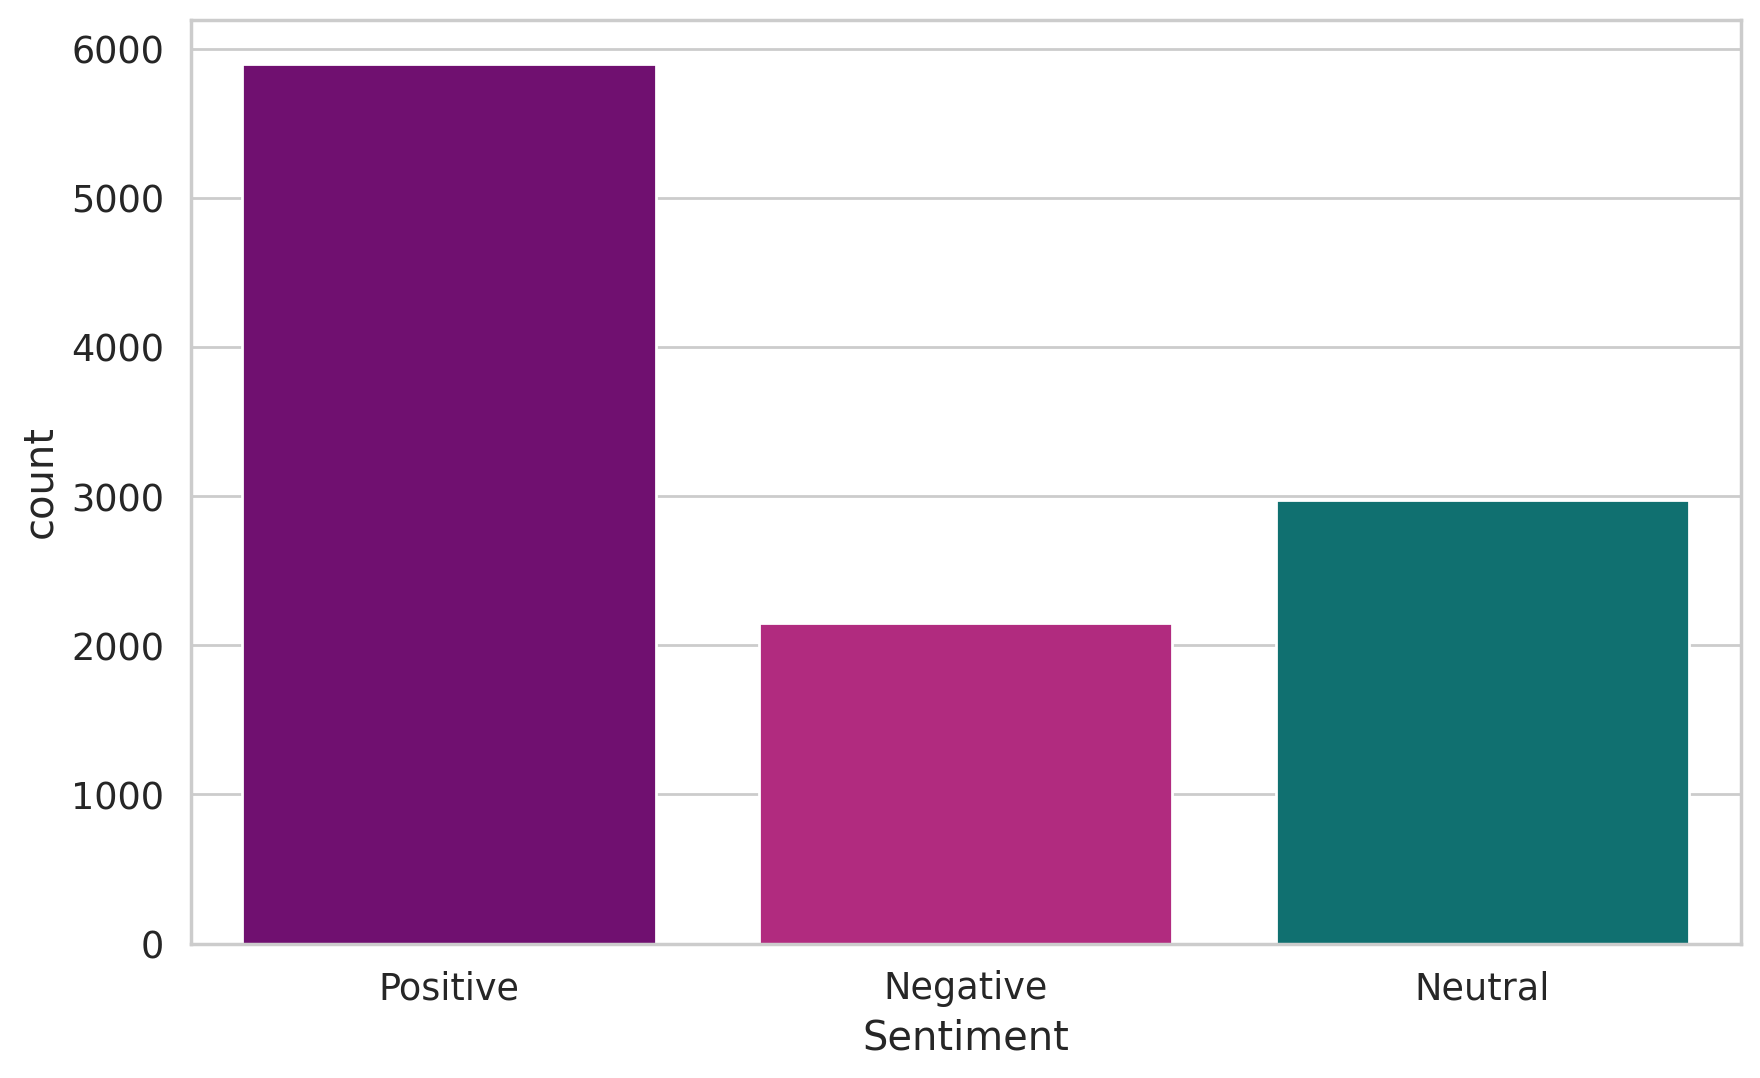

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(10, 6))

custom_palette = ['Purple', 'MediumVioletRed', 'teal']

sns.countplot(x='Sentiment', data=df, palette=custom_palette)
# Rename the x-axis tick labels
new_labels = class_names# Replace with your desired labels
plt.gca().set_xticklabels(new_labels)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def visualize_text_length(data, title):

    data['text_length'] = data['review'].apply(len)

    plt.figure(figsize=(8, 4))

    custom_font = FontProperties(family='serif', style='normal', size=14, weight='bold')

    plt.hist(data['text_length'], bins=40, color='lightcoral', edgecolor='black', alpha=0.7, label='Bangla News Article')
    plt.grid(linestyle='--', alpha=0.6)
    plt.xlabel("Text Length", fontsize=10, fontproperties=custom_font, color='black')
    plt.ylabel("Frequency", fontsize=10, fontproperties=custom_font, color='black')

    plt.title(f'Text Length Distribution for {title}', fontsize=12, fontproperties=custom_font, color='black')

    # Show the plot
    plt.show()




# **Visualize text length distribution**

In [ ]:
visualize_text_length(df, 'Top 10 IMDB TV Series Reviews Dataset')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def visualize_word_count(data, title):
    # calculate the word count for each entry in the 'bangla_speech' and 'sylhet_bangla_speech' columns and store the results in new columns
    data['review_word_count'] = data['review'].apply(lambda x: len(str(x).split()))

    # Create a figure with a larger size
    plt.figure(figsize=(8, 4))

    # Define a custom font with a nice appearance
    custom_font = FontProperties(family='serif', style='normal', size=14, weight='bold')

    # First subplot for 'Bangla Speech' word count distribution
    
    plt.hist(data['review_word_count'], bins=40, color='steelblue', edgecolor='black', alpha=0.7, label='Bangla Speech')
    plt.grid(linestyle='--', alpha=0.6)
    plt.xlabel("Word Count", fontsize=10, fontproperties=custom_font, color='black')
    plt.ylabel("Frequency", fontsize=10, fontproperties=custom_font, color='black')

  
    # Set a single title for the entire figure
    plt.title(f'Word Count Distribution for {title}', fontsize=12, fontproperties=custom_font, color='black')
    # Adjust the layout for subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


# **Visualize word count distribution**

In [ ]:
visualize_word_count(df, 'Top 10 IMDB TV Series Reviews Dataset')

In [ ]:
from wordcloud import WordCloud

def create_wordcloud(data, column, title):
    # Specify a Bangla-supported font, such as "Siyam Rupali"



    #This setting disables the detection of collocations (multi-word phrases) to focus on individual words.
    wordcloud = WordCloud(width=800, height=400, background_color='black',
                          colormap='cividis', collocations=False).generate(' '.join(data[column]))

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {column} in {title}', fontsize=16, color='black')
    plt.axis('off')
    plt.show()

# ***Word Cloud***

In [ ]:
create_wordcloud(df, 'review', 'Top 10 IMDB TV Series Reviews Dataset')

In [ ]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' 

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'True to the books'

In [ ]:

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

In [ ]:
token_lens = []

for txt in df.review:
  #tokenizing the text
      tokens = tokenizer.encode(txt, max_length=512)
      token_lens.append(len(tokens))

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 600]);
plt.xlabel('Token count');

In [ ]:
selected_columns = ['review', 'Sentiment']
df = df[selected_columns]

In [ ]:
MAX_LEN = 512

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.30, shuffle=True)
df_val, df_test = train_test_split(df_test, test_size=0.50,shuffle=True)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

In [ ]:

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.Sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [ ]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # method name

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

# **SentimentClassifier**

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #model
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(3)
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

# ***Training***

In [ ]:
EPOCHS = 25

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
from tqdm import tqdm
import torch.nn as nn
import numpy as np

def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    # tqdm for progress monitoring
    data_loader = tqdm(data_loader, desc="Training", unit="batch")

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update tqdm description with the current loss
        data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
from tqdm import tqdm
import torch
import numpy as np

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    
    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
import warnings

# Ignore FutureWarnings from the tokenization_utils_base module
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.tokenization_utils_base")


In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


# ***Evaluation***

In [ ]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values


In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# ***Let's have a look at the classification report***

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

# ***Confusion Matrix***

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = accuracy * 100

# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.mpl_palette("Set2", as_cmap=True)
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=class_names, yticklabels=class_names,vmin=0,vmax=150,
                      annot_kws={"family": "Serif", 'color':'black','weight': 'bold', 'size': 13})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font2)
heatmap.set_ylabel('Target Labels', fontdict=font2)
heatmap.set_title('Review classification \nAccuracy: {:.2f}%'.format(accuracy_percentage),
                  fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space


plt.show()


In [ ]:
idx = 40

review_text = y_review_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True Label: {class_names[true_label]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Label')
plt.xlabel('probability')
plt.xlim([0, 1]);